In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")

Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
import logging
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

from hydro_forecasting.experiment_utils.seed_manager import SeedManager  # noqa: E402

seed_manager = SeedManager(42)
seed_manager.set_global_seeds()

2025-06-25 09:53:04,945 - hydro_forecasting.experiment_utils.seed_manager - INFO - SeedManager initialized with master seed: 42
2025-06-25 09:53:04,946 - lightning_fabric.utilities.seed - INFO - Seed set to 42


In [3]:
import hydro_forecasting.experiment_utils.checkpoint_manager as checkpoint_manager
from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig
from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule
from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml
from hydro_forecasting.model_evaluation.visualization import (
    plot_basin_performance_scatter,
    plot_horizon_performance_bars,
    plot_horizon_performance_boxplots,
    plot_model_cdf_grid,
)
from hydro_forecasting.models.dummy import LitRepeatLastValues, RepeatLastValuesConfig
from hydro_forecasting.models.ealstm import EALSTMConfig, LitEALSTM
from hydro_forecasting.models.tft import LitTFT, TFTConfig
from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.models.tsmixer import LitTSMixer, TSMixerConfig
from hydro_forecasting.preprocessing import PipelineBuilder

---

In [4]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

target = "streamflow"

In [5]:
REGIONS = ["CA"]

COUNTRY = "tajikistan"

MODEL_TYPES = [
    "tft",
    "ealstm",
    "tide",
    "tsmixer",
]

EXPERIMENT_TYPES = {
    # "pretrained": f"similar_catchments/similar-catchments_{COUNTRY.lower()}",
    # "finetuned": f"finetune/finetune_from_similar_catchments_{COUNTRY.lower()}",
    "benchmark": f"benchmark/benchmark_unified_{COUNTRY.lower()}",
    # "low_hii": f"low-medium-hii/low-medium-hii_{COUNTRY.lower()}",
}

BASE_PATH = Path("/Users/cooper/Desktop/hydro-forecasting/experiments")

In [6]:
ealstm_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/unified/{COUNTRY.lower()}/ealstm.yaml"
tft_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/unified/{COUNTRY.lower()}/tft.yaml"
tide_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/unified/{COUNTRY.lower()}/tide.yaml"
tsmixer_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/unified/{COUNTRY.lower()}/tsmixer.yaml"


tft_hp = hp_from_yaml("tft", tft_yaml)
tide_hp = hp_from_yaml("tide", tide_yaml)
ealstm_hp = hp_from_yaml("ealstm", ealstm_yaml)
tsmixer_hp = hp_from_yaml("tsmixer", tsmixer_yaml)

The following parameters were not found in the YAML file and will use defaults:
  - use_rev_in (standard)
The following parameters were not found in the YAML file and will use defaults:
  - use_rev_in (standard)
The following parameters were not found in the YAML file and will use defaults:
  - use_rev_in (standard)
The following parameters were not found in the YAML file and will use defaults:
  - use_rev_in (standard)


In [7]:
TFT_config = TFTConfig(**tft_hp)
EALSTM_config = EALSTMConfig(**ealstm_hp)
TiDE_config = TiDEConfig(**tide_hp)
TSMixer_config = TSMixerConfig(**tsmixer_hp)

dummy_config = RepeatLastValuesConfig(
    input_len=ealstm_hp["input_len"],
    input_size=ealstm_hp["input_size"],
    output_len=ealstm_hp["output_len"],
)

---

In [8]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


country_ids = load_basin_ids(COUNTRY)

In [9]:
print(f"Found {len(country_ids)} total CA basins in {COUNTRY}")

Found 16 total CA basins in tajikistan


---

In [ ]:
builder = PipelineBuilder()

feature_section = (
    builder.features()
    .transforms(["standard_scale"])
    .strategy("unified", fit_on_n_basins=200)
    .columns(forcing_features)
)

target_section = (
    builder.target()
    .transforms(["log_scale", "standard_scale"])
    .strategy("per_group", group_by="gauge_id")
    .columns([target])
)

static_section = (
    builder.static_features()
    .transforms(["standard_scale"])
    .strategy("unified")
    .columns(static_features)
)

preprocessing_config = builder.build()

preprocessing_config["static_features"].keys()

dict_keys(['pipeline', 'strategy', 'columns'])

In [11]:
region_time_series_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/timeseries/csv/{region}"
    for region in REGIONS
}

region_static_attributes_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/attributes/{region}" for region in REGIONS
}

In [12]:
data_modules = {
    name: HydroInMemoryDataModule(
        region_time_series_base_dirs=region_time_series_base_dirs,
        region_static_attributes_base_dirs=region_static_attributes_base_dirs,
        path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/data_cache/first_eval",
        group_identifier="gauge_id",
        batch_size=2048,
        input_length=hp["input_len"],
        output_length=hp["output_len"],
        forcing_features=forcing_features,
        static_features=static_features,
        target=target,
        preprocessing_configs=preprocessing_config,
        num_workers=4,
        min_train_years=5,
        train_prop=0.5,
        val_prop=0.25,
        test_prop=0.25,
        max_imputation_gap_size=5,
        list_of_gauge_ids_to_process=country_ids,
        is_autoregressive=True,
        chunk_size=100,
        validation_chunk_size=100,
        random_seed=42,
    )
    for name, hp in [
        ("tft_data_module", tft_hp),
        ("tide_data_module", tide_hp),
        ("tsmixer_data_module", tsmixer_hp),
        ("ealstm_data_module", ealstm_hp),
    ]
}

tft_data_module = data_modules["tft_data_module"]
tide_data_module = data_modules["tide_data_module"]
tsmixer_data_module = data_modules["tsmixer_data_module"]
ealstm_data_module = data_modules["ealstm_data_module"]

2025-06-25 09:53:05,526 - hydro_forecasting.experiment_utils.seed_manager - INFO - SeedManager initialized with master seed: 42
2025-06-25 09:53:05,527 - lightning_fabric.utilities.seed - INFO - Seed set to 42
2025-06-25 09:53:05,529 - hydro_forecasting.data.in_memory_datamodule - INFO - Initialized SeedManager with seed: 42
2025-06-25 09:53:05,530 - hydro_forecasting.experiment_utils.seed_manager - INFO - SeedManager initialized with master seed: 42
2025-06-25 09:53:05,530 - lightning_fabric.utilities.seed - INFO - Seed set to 42
2025-06-25 09:53:05,532 - hydro_forecasting.data.in_memory_datamodule - INFO - Initialized SeedManager with seed: 42
2025-06-25 09:53:05,532 - hydro_forecasting.experiment_utils.seed_manager - INFO - SeedManager initialized with master seed: 42
2025-06-25 09:53:05,533 - lightning_fabric.utilities.seed - INFO - Seed set to 42
2025-06-25 09:53:05,534 - hydro_forecasting.data.in_memory_datamodule - INFO - Initialized SeedManager with seed: 42
2025-06-25 09:53:05

In [13]:
from hydro_forecasting.exceptions import ConfigurationError, FileOperationError


def get_checkpoint_for_model(model_type: str, checkpoint_folder: Path, select_overall_best: bool = True) -> Path | None:
    """
    Function to get the best checkpoint for a given model type.

    Args:
        model_type: Type of model to load checkpoint for
        checkpoint_folder: Base directory containing checkpoints
        select_overall_best: Whether to select the overall best model

    Returns:
        Path to checkpoint file, or None if not found or error occurred
    """
    try:
        return checkpoint_manager.get_checkpoint_path_to_load(
            base_checkpoint_load_dir=checkpoint_folder, model_type=model_type, select_overall_best=select_overall_best
        )
    except (ConfigurationError, FileOperationError) as e:
        print(f"Failed to load checkpoint for {model_type}: {e}")
        return None


def load_all_checkpoints(
    country: str, model_types: list[str] | None = None, experiment_types: dict[str, str] | None = None
) -> dict[str, dict[str, Path | None]]:
    """
    Load checkpoints for all model types across all experiment types.

    Args:
        country: Country code for the experiments
        model_types: List of model types to load (defaults to common ones)
        experiment_types: Dict mapping experiment names to directory patterns

    Returns:
        Dict of {experiment_type: {model_type: checkpoint_path}}
    """
    # Default model types
    if model_types is None:
        model_types = ["tft", "tide", "ealstm", "tsmixer"]

    base_path = BASE_PATH
    checkpoints = {}

    for exp_name, exp_path in experiment_types.items():
        checkpoints[exp_name] = {}
        checkpoint_dir = base_path / exp_path / "checkpoints"

        for model_type in model_types:
            checkpoint_path = get_checkpoint_for_model(
                model_type=model_type, checkpoint_folder=checkpoint_dir, select_overall_best=True
            )
            checkpoints[exp_name][model_type] = checkpoint_path

    return checkpoints


def print_checkpoints(checkpoints: dict[str, dict[str, Path | None]]) -> None:
    """Print checkpoints in a readable format."""
    for exp_name, models in checkpoints.items():
        valid_paths = [str(path) for path in models.values() if path is not None]
        failed_models = [model for model, path in models.items() if path is None]

        print(f"{exp_name.capitalize()} checkpoints: {', '.join(valid_paths)}")
        if failed_models:
            print(f"  Failed to load: {', '.join(failed_models)}")


checkpoints = load_all_checkpoints(COUNTRY, MODEL_TYPES, EXPERIMENT_TYPES)
print_checkpoints(checkpoints)

Benchmark checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_unified_tajikistan/checkpoints/tft/run_0/attempt_0/tft-run0-attempt_0-epoch=61-val_loss=0.0927.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_unified_tajikistan/checkpoints/ealstm/run_0/attempt_0/ealstm-run0-attempt_0-epoch=21-val_loss=0.1114.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_unified_tajikistan/checkpoints/tide/run_0/attempt_0/tide-run0-attempt_0-epoch=32-val_loss=0.1209.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_unified_tajikistan/checkpoints/tsmixer/run_0/attempt_0/tsmixer-run0-attempt_0-epoch=45-val_loss=0.1178.ckpt


In [14]:
# tft_pretrained_checkpoint = checkpoints["pretrained"]["tft"]
# tide_pretrained_checkpoint = checkpoints["pretrained"]["tide"]
# ealstm_pretrained_checkpoint = checkpoints["pretrained"]["ealstm"]
# tsmixer_pretrained_checkpoint = checkpoints["pretrained"]["tsmixer"]

# tft_finetuned_checkpoint = checkpoints["finetuned"]["tft"]
# tide_finetuned_checkpoint = checkpoints["finetuned"]["tide"]
# ealstm_finetuned_checkpoint = checkpoints["finetuned"]["ealstm"]
# tsmixer_finetuned_checkpoint = checkpoints["finetuned"]["tsmixer"]

tft_benchmark_checkpoint = checkpoints["benchmark"]["tft"]
tide_benchmark_checkpoint = checkpoints["benchmark"]["tide"]
ealstm_benchmark_checkpoint = checkpoints["benchmark"]["ealstm"]
tsmixer_benchmark_checkpoint = checkpoints["benchmark"]["tsmixer"]

# tft_low_hii_checkpoint = checkpoints["low_hii"]["tft"]
# tide_low_hii_checkpoint = checkpoints["low_hii"]["tide"]
# ealstm_low_hii_checkpoint = checkpoints["low_hii"]["ealstm"]
# tsmixer_low_hii_checkpoint = checkpoints["low_hii"]["tsmixer"]

In [15]:
dummy_model = LitRepeatLastValues(config=dummy_config)
ealstm_benchmark_model = LitEALSTM.load_from_checkpoint(ealstm_benchmark_checkpoint, config=EALSTM_config)
tide_benchmark_model = LitTiDE.load_from_checkpoint(tide_benchmark_checkpoint, config=TiDE_config)
tsmixer_benchmark_model = LitTSMixer.load_from_checkpoint(tsmixer_benchmark_checkpoint, config=TSMixer_config)
tft_benchmark_model = LitTFT.load_from_checkpoint(tft_benchmark_checkpoint, config=TFT_config)

# ealstm_pretrained_model = LitEALSTM.load_from_checkpoint(ealstm_pretrained_checkpoint, config=EALSTM_config)
# tide_pretrained_model = LitTiDE.load_from_checkpoint(tide_pretrained_checkpoint, config=TiDE_config)
# tsmixer_pretrained_model = LitTSMixer.load_from_checkpoint(tsmixer_pretrained_checkpoint, config=TSMixer_config)
# tft_pretrained_model = LitTFT.load_from_checkpoint(tft_pretrained_checkpoint, config=TFT_config)

# ealstm_finetuned_model = LitEALSTM.load_from_checkpoint(ealstm_finetuned_checkpoint, config=EALSTM_config)
# tide_finetuned_model = LitTiDE.load_from_checkpoint(tide_finetuned_checkpoint, config=TiDE_config)
# tsmixer_finetuned_model = LitTSMixer.load_from_checkpoint(tsmixer_finetuned_checkpoint, config=TSMixer_config)
# tft_finetuned_model = LitTFT.load_from_checkpoint(tft_finetuned_checkpoint, config=TFT_config)

# tft_low_hii_model = LitTFT.load_from_checkpoint(tft_low_hii_checkpoint, config=TFT_config)
# tide_low_hii_model = LitTiDE.load_from_checkpoint(tide_low_hii_checkpoint, config=TiDE_config)
# ealstm_low_hii_model = LitEALSTM.load_from_checkpoint(ealstm_low_hii_checkpoint, config=EALSTM_config)
# tsmixer_low_hii_model = LitTSMixer.load_from_checkpoint(tsmixer_low_hii_checkpoint, config=TSMixer_config)


# Create a dictionary mapping model names to (model, datamodule) tuples
models_and_datamodules = {
    "ealstm_benchmark": (ealstm_benchmark_model, ealstm_data_module),
    # "ealstm_pretrained": (ealstm_pretrained_model, ealstm_data_module),
    # "ealstm_finetuned": (ealstm_finetuned_model, ealstm_data_module),
    "tide_benchmark": (tide_benchmark_model, tide_data_module),
    # "tide_pretrained": (tide_pretrained_model, tide_data_module),
    # "tide_finetuned": (tide_finetuned_model, tide_data_module),
    "tsmixer_benchmark": (tsmixer_benchmark_model, tsmixer_data_module),
    # "tsmixer_pretrained": (tsmixer_pretrained_model, tsmixer_data_module),
    # "tsmixer_finetuned": (tsmixer_finetuned_model, tsmixer_data_module),
    # "tft_benchmark": (tft_benchmark_model, tft_data_module),
    # "tft_pretrained": (tft_pretrained_model, tft_data_module),
    # "tft_finetuned": (tft_finetuned_model, tft_data_module),
    # "tft_low_hii": (tft_low_hii_model, tft_data_module),
    # "tide_low_hii": (tide_low_hii_model, tide_data_module),
    # "ealstm_low_hii": (ealstm_low_hii_model, ealstm_data_module),
    # "tsmixer_low_hii": (tsmixer_low_hii_model, tsmixer_data_module),
    "dummy": (dummy_model, ealstm_data_module),
}


evaluator = TSForecastEvaluator(
    horizons=list(range(1, 11)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={"accelerator": "mps", "devices": 1, "deterministic": True, "benchmark": False},
)

/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.5.1.post0


In [16]:
# Run evaluation
results = evaluator.test_models(
    start_of_season=4,
    end_of_season=10,
    cache_path=f"/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_{COUNTRY.lower()}",
    force_refresh=True,
)

2025-06-25 09:53:05,751 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing models: ealstm_benchmark, tide_benchmark, tsmixer_benchmark, dummy (4/4 models)
2025-06-25 09:53:05,752 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing model: ealstm_benchmark
2025-06-25 09:53:05,769 - pytorch_lightning.utilities.rank_zero - INFO - Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
2025-06-25 09:53:05,773 - pytorch_lightning.utilities.rank_zero - INFO - GPU available: True (mps), used: True
2025-06-25 09:53:05,774 - pytorch_lightning.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
2025-06-25 09:53:05,775 - pytorch_lightning.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs
2025-06-25 09:53:05,785 - hydro_forecasting.data.in_memory_datamodule - INFO - Starting data preparation...
2025-06-25 09:53:05,786 - hydro_forecasting.d

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.07840698212385178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2025-06-25 09:53:19,723 - hydro_forecasting.model_evaluation.evaluators - INFO - Applying seasonal filter: months 4 to 9
2025-06-25 09:53:19,853 - hydro_forecasting.model_evaluation.evaluators - ERROR - Failed to save ealstm_benchmark to cache: Cannot save file into a non-existent directory: '/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_tajikistan/predictions'
2025-06-25 09:53:19,854 - hydro_forecasting.model_evaluation.evaluators - ERROR - Failed to test model ealstm_benchmark: Cannot save file into a non-existent directory: '/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_tajikistan/predictions'
2025-06-25 09:53:19,854 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing model: tide_benchmark
2025-06-25 09:53:19,856 - pytorch_lightning.utilities.rank_zero - INFO - Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.0786195918917656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2025-06-25 09:53:32,055 - hydro_forecasting.model_evaluation.evaluators - INFO - Applying seasonal filter: months 4 to 9
2025-06-25 09:53:32,194 - hydro_forecasting.model_evaluation.evaluators - ERROR - Failed to save tide_benchmark to cache: Cannot save file into a non-existent directory: '/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_tajikistan/predictions'
2025-06-25 09:53:32,194 - hydro_forecasting.model_evaluation.evaluators - ERROR - Failed to test model tide_benchmark: Cannot save file into a non-existent directory: '/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_tajikistan/predictions'
2025-06-25 09:53:32,195 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing model: tsmixer_benchmark
2025-06-25 09:53:32,197 - pytorch_lightning.utilities.rank_zero - INFO - Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.09798303246498108
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2025-06-25 09:53:44,674 - hydro_forecasting.model_evaluation.evaluators - INFO - Applying seasonal filter: months 4 to 9
2025-06-25 09:53:44,801 - hydro_forecasting.model_evaluation.evaluators - ERROR - Failed to save tsmixer_benchmark to cache: Cannot save file into a non-existent directory: '/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_tajikistan/predictions'
2025-06-25 09:53:44,802 - hydro_forecasting.model_evaluation.evaluators - ERROR - Failed to test model tsmixer_benchmark: Cannot save file into a non-existent directory: '/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_tajikistan/predictions'
2025-06-25 09:53:44,802 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing model: dummy
2025-06-25 09:53:44,804 - pytorch_lightning.utilities.rank_zero - INFO - Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
2025-

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.1137363463640213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2025-06-25 09:53:56,698 - hydro_forecasting.model_evaluation.evaluators - INFO - Applying seasonal filter: months 4 to 9
2025-06-25 09:53:56,847 - hydro_forecasting.model_evaluation.evaluators - ERROR - Failed to save dummy to cache: Cannot save file into a non-existent directory: '/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_tajikistan/predictions'
2025-06-25 09:53:56,847 - hydro_forecasting.model_evaluation.evaluators - ERROR - Failed to test model dummy: Cannot save file into a non-existent directory: '/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_tajikistan/predictions'


In [17]:
sns.set_context(context="paper", font_scale=1.3)

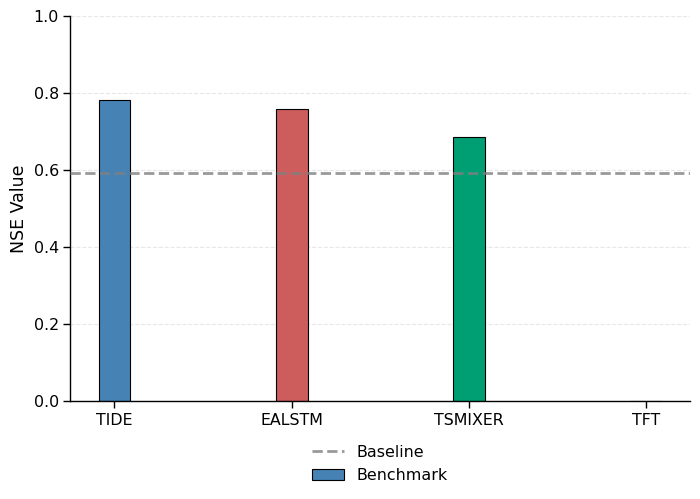

In [18]:
fig, ax = plot_horizon_performance_bars(
    results,
    horizon=10,
    metric="nse",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(8, 5),
    with_whiskers=False,
    positive_is_better=True,
    dummy_model="dummy",
)
ax.set_ylim(0, 1)
sns.despine()
plt.show()

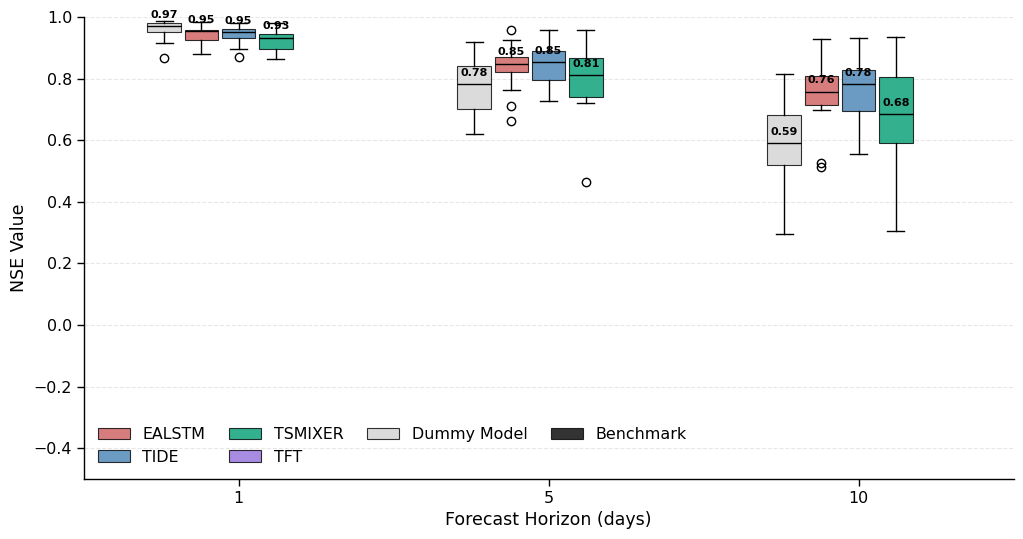

In [19]:
fig, ax = plot_horizon_performance_boxplots(
    results,
    horizons=[1, 5, 10],
    metric="nse",
    architectures=["ealstm", "tide", "tsmixer", "tft"],
    variants=["benchmark"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 6),
    show_median_labels=True,
    dummy_model="dummy",
)

ax.set_ylim(-0.5, 1)
ax.set_title("")
sns.despine()
plt.show()

/Users/cooper/Desktop/hydro-forecasting/src/hydro_forecasting/model_evaluation/visualization.py:474: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


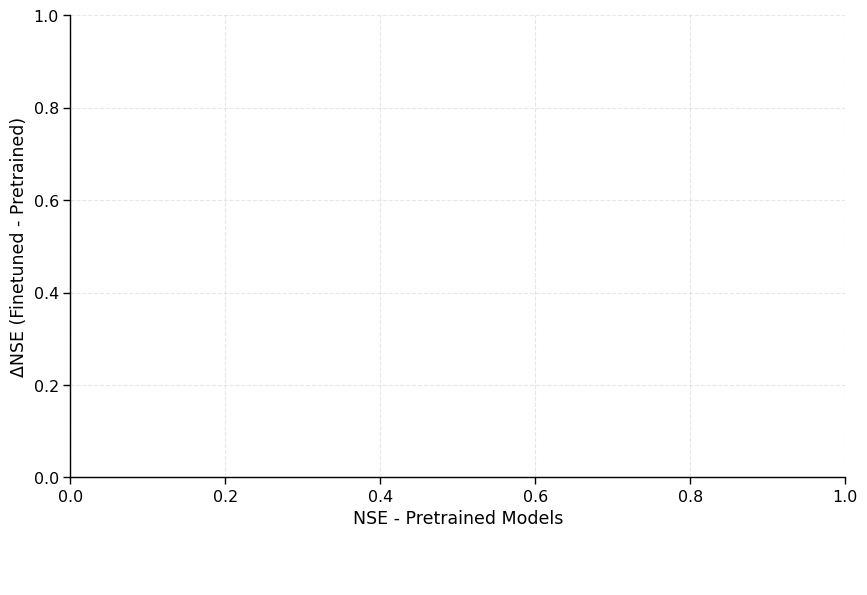

In [20]:
fig, ax = plot_basin_performance_scatter(
    results,
    benchmark_pattern="pretrained",
    challenger_pattern="finetuned",
    horizon=10,
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    metric="nse",
    figsize=(10, 6),
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    debug=True,
)
sns.despine()
plt.show()

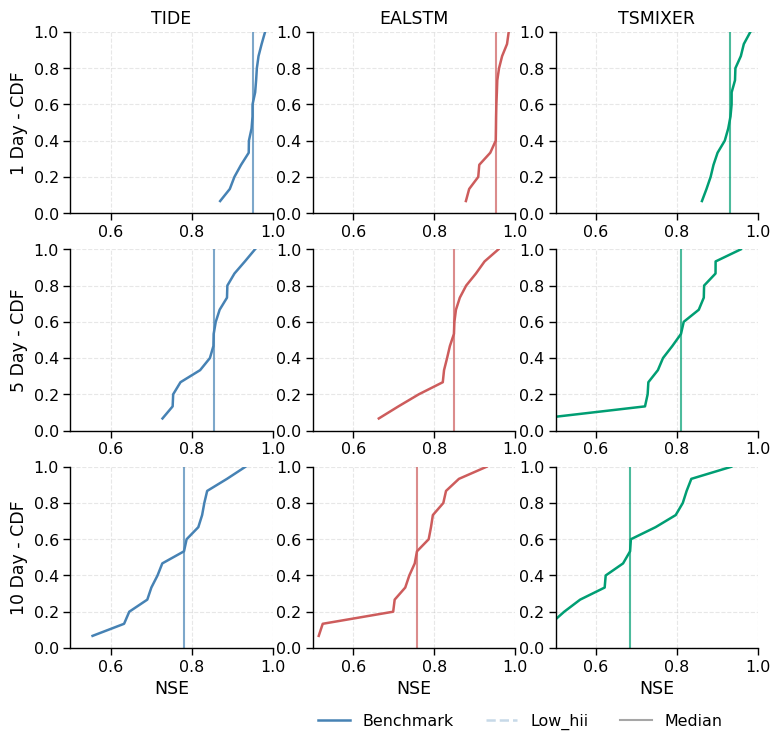

In [21]:
fig, axes = plot_model_cdf_grid(
    results,
    horizons=[1, 5, 10],
    metric="nse",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "low_hii"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 8),
)
sns.despine()
plt.show()

In [22]:
# fig, ax = plot_rolling_forecast(
#     results,
#     model_name="tsmixer_finetuned",
#     gauge_id="CA_15016",
#     horizon=1,
#     figsize=(10, 5),
#     color_scheme={"observed": "#2E4057", "predicted": "#FF6B35"},
# )

# sns.despine()
# ax.set_xlabel("")
# ax.set_ylabel("Streamflow (mm/day)")

# plt.show()

In [23]:
# config_ca = CaravanifyParquetConfig(
#     attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
#     timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
#     shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/shapefiles",
#     gauge_id_prefix="CA",
#     use_hydroatlas_attributes=True,
#     use_caravan_attributes=True,
#     use_other_attributes=True,
# )

# caravan_ca = CaravanifyParquet(config_ca)

# caravan_ca._load_static_attributes(country_ids)
# statics = caravan_ca.get_static_attributes()


# fig, axes = plot_performance_vs_static_attributes(
#     results,
#     static_df=statics,
#     static_attributes=["p_mean", "ele_mt_sav", "frac_snow"],
#     model_names=["tide_low_hii"],
#     horizons=[5],
#     metric="nse",
#     figsize=(11, 4),
#     attribute_labels={
#         "p_mean": "Mean Precipitation (mm/d)",
#         "ele_mt_sav": "Mean Elevation (m.a.s.l.)",
#         "frac_snow": "Precipitation Falling as Snow (%)",
#     },
# )

# sns.despine()
# # set y lim to (0, 1)
# for ax in axes.flatten():
#     ax.set_ylim(0.0, 1)
#     ax.set_title("")
# plt.show()
